In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from concurrent.futures import ThreadPoolExecutor
from geopy.geocoders import Photon
import folium
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataframe_venda = pd.read_parquet('dados_webscraping/dataframe_imoveis_venda_pronto_para_analise.parquet')

print("Quantidade de imóveis: ", dataframe_venda.shape[0])
print("Porcentagem de informações faltantes: ")
display(round(dataframe_venda.isna().sum()/dataframe_venda.shape[0] * 100, 2).astype(str) + " %")

Quantidade de imóveis:  3861
Porcentagem de informações faltantes: 


url                          0.0 %
endereco                     0.0 %
preco                        0.0 %
area                         0.0 %
quartos                      0.0 %
vagas_de_carro               0.0 %
valor_condominio             0.0 %
iptu                         0.0 %
mobiliado                    0.0 %
piscina                      0.0 %
condominio                   0.0 %
elevador                     0.0 %
jardim                       0.0 %
quadra_esportiva             0.0 %
academia                     0.0 %
finalidade                   0.0 %
tipo                         0.0 %
localizacao                  0.0 %
latitude                     0.0 %
longitude                    0.0 %
geometry                     0.0 %
nome                       11.34 %
distancia_metro            10.98 %
distancia_escola           10.98 %
distancia_unidade_saude    10.98 %
indic_rend                 11.34 %
indic_lixo                 11.34 %
indic_esgo                 11.34 %
indic_agua          

In [9]:
dataframe_final = dataframe_venda.dropna()

print("Quantidade de imóveis: ", dataframe_final.shape[0])

Quantidade de imóveis:  3423


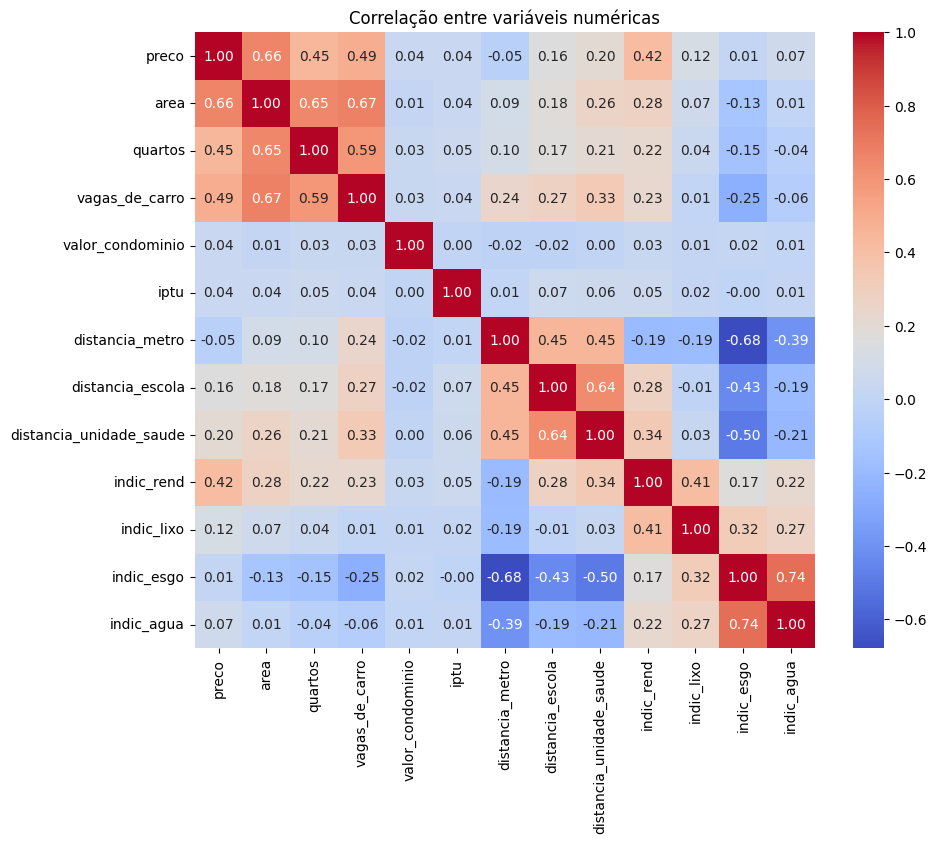

In [10]:
# Seleção de colunas numéricas
numeric_cols = dataframe_final.select_dtypes(include=['float64', 'int64'])

# Matriz de correlação
correlation_matrix = numeric_cols.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis numéricas")
plt.show()

### Observações

#### 1 - Multicolinearidade: Colunas altamente correlacionadas entre si podem impactar negativamente o desempenho de modelos lineares ou baseados em matriz inversa (como regressões). Por exemplo:

* indic_esgo e indic_agua têm correlação muito alta (0.741). Manter ambas pode ser redundante, então considere escolher uma delas.

* distancia_escola e distancia_unidade_saude têm uma correlação alta (0.637), indicando que elas capturam informações semelhantes.


#### 2 - Relevância para a variável-alvo: Priorize colunas com alta correlação com preco (variável dependente). Abaixo, estão algumas considerações:

* area (0.661) e quartos (0.449) são relevantes e não devem ser removidos.

* Colunas com correlação próxima de zero, como valor_condominio (0.041) e iptu (0.041), têm impacto mínimo no preço. Elas podem ser candidatas à exclusão, dependendo do contexto.

In [11]:
dataframe_final = dataframe_final.drop(columns=["indic_esgo", "distancia_escola", "iptu", "valor_condominio"])
dataframe_final.dtypes

url                         object
endereco                    object
preco                      float64
area                       float64
quartos                    float64
vagas_de_carro               int64
mobiliado                     bool
piscina                       bool
condominio                    bool
elevador                      bool
jardim                        bool
quadra_esportiva              bool
academia                      bool
finalidade                  object
tipo                        object
localizacao                 object
latitude                    object
longitude                   object
geometry                    object
nome                        object
distancia_metro            float64
distancia_unidade_saude    float64
indic_rend                 float64
indic_lixo                 float64
indic_agua                 float64
dtype: object

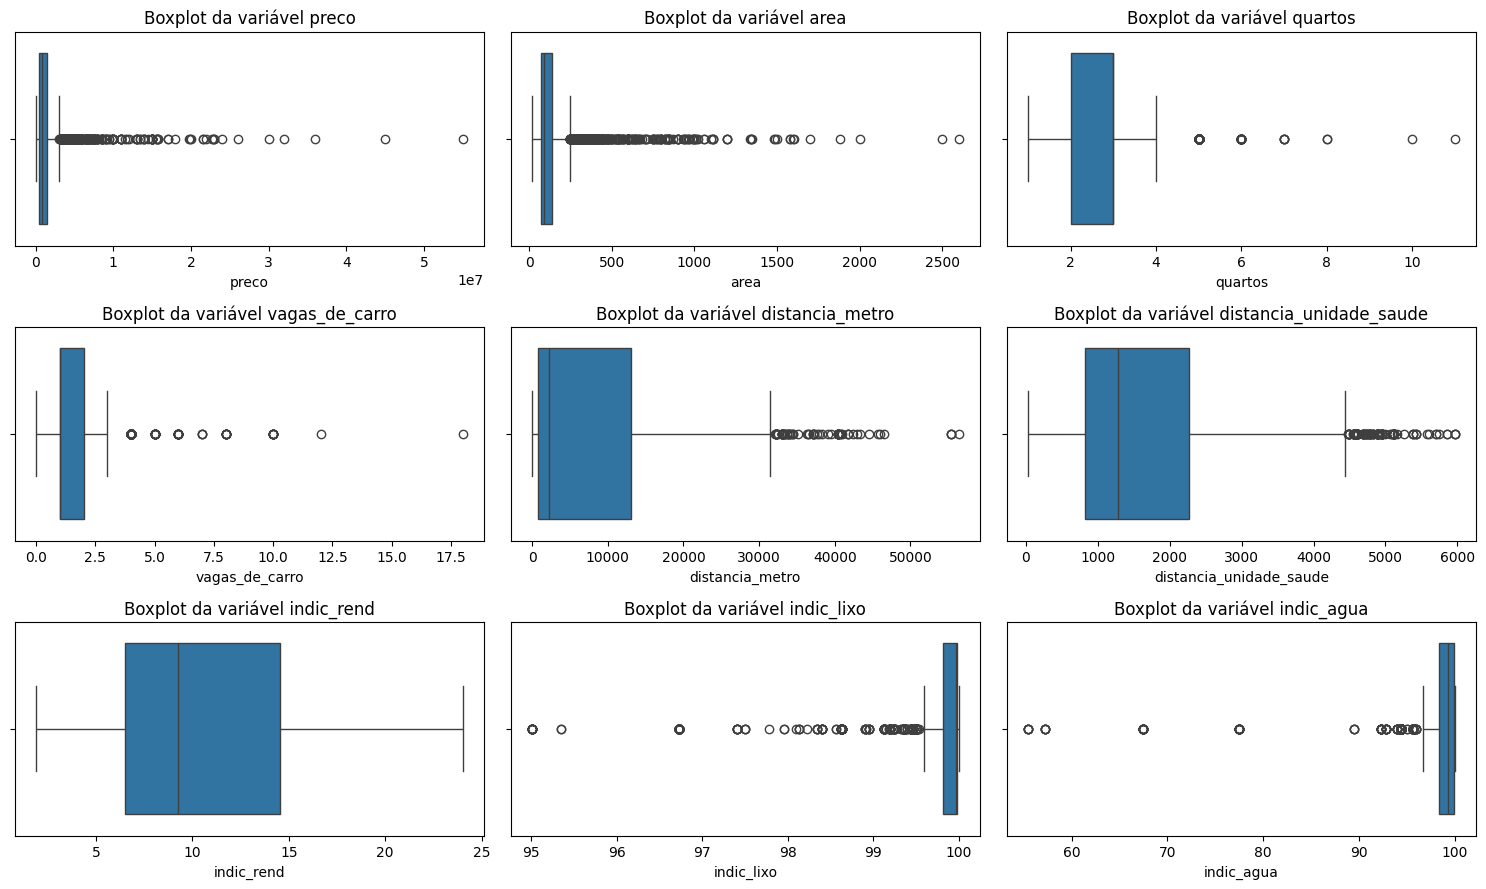

(3423, 25)


In [15]:
def plotar_boxplot(dataframe, colunas=['preco', 'area', 'quartos', 'vagas_de_carro', 'valor_condominio', 'distancia_metro', 'distancia_escola', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_agua'], tipo="boxplot"):

    # Número de colunas e linhas para subplots
    num_colunas = 3
    num_linhas = len(colunas) // num_colunas + (1 if len(colunas) % num_colunas != 0 else 0)

    # Criar os subplots
    plt.figure(figsize=(15, 3 * num_linhas))

    # Criar um boxplot para cada variável em cada subplot
    for i, coluna in enumerate(colunas):
        if tipo == "boxplot":
            plt.subplot(num_linhas, num_colunas, i + 1)
            sns.boxplot(x=dataframe[coluna])
            plt.title(f"Boxplot da variável {coluna}")
        if tipo == "histograma":
            plt.subplot(num_linhas, num_colunas, i + 1)
            sns.histplot(dataframe[coluna])
            plt.title(f"Histograma da variável {coluna}")
    
    # Ajustar o layout para não sobrepor os gráficos
    plt.tight_layout()
    plt.show()

colunas_analise = ['preco', 'area', 'quartos', 'vagas_de_carro', 
                   'distancia_metro', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_agua']
plotar_boxplot(dataframe_final, colunas_analise)

print(dataframe_final.shape)


(1139, 25)


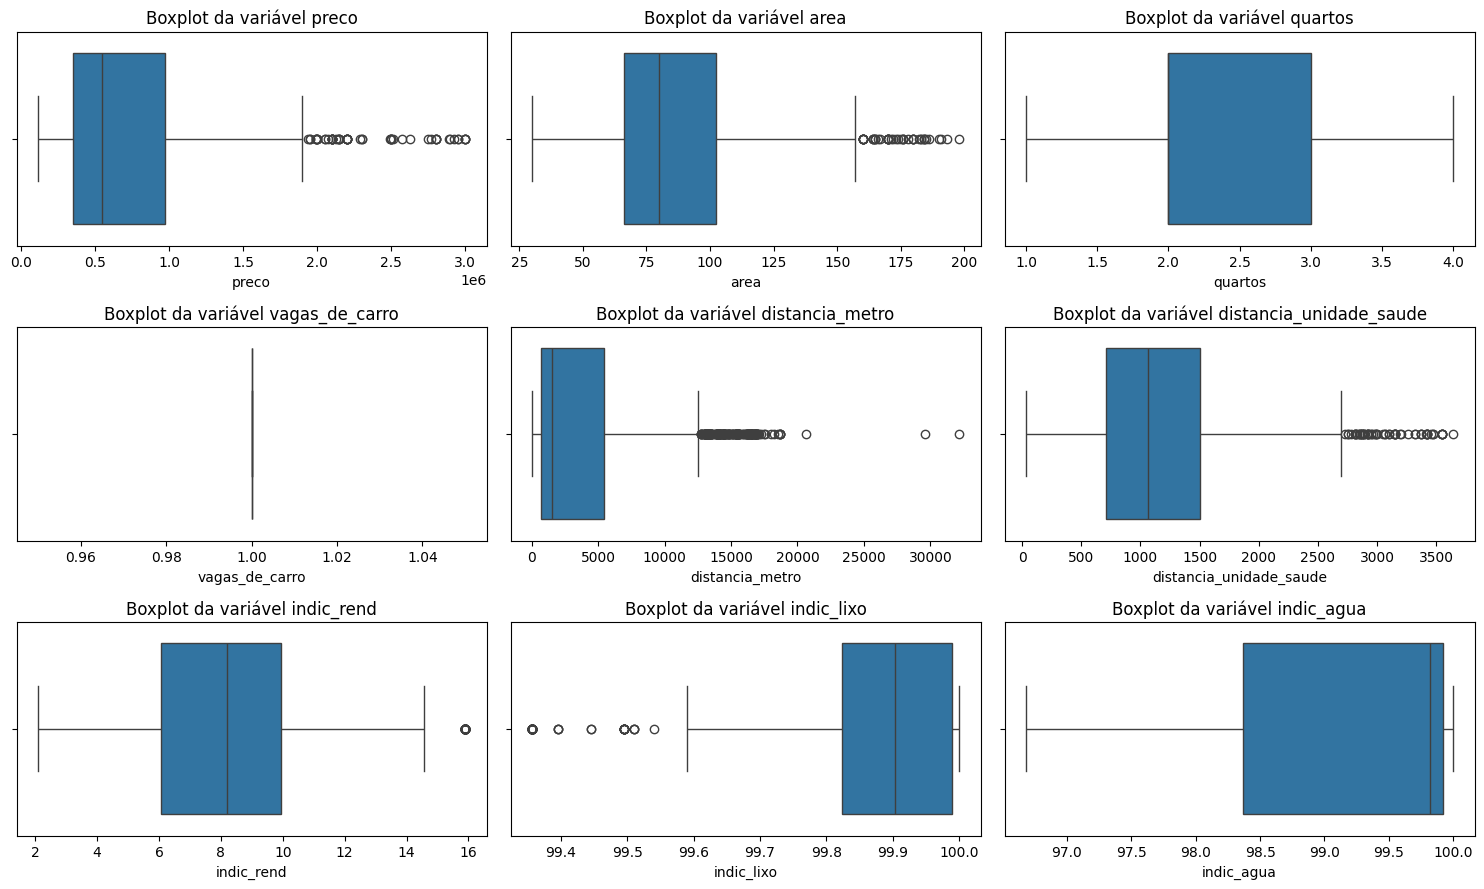

In [21]:
def identificar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return limite_inferior, limite_superior

# Remover outliers
for coluna in colunas_analise:
    limite_inferior, limite_superior = identificar_outliers(dataframe_final, coluna)
    dataframe_final = dataframe_final[
        (dataframe_final[coluna] >= limite_inferior) & (dataframe_final[coluna] <= limite_superior)
    ]
#dataframe_final = dataframe_final[dataframe_final["preco"] < 30000]

print(dataframe_final.shape)
plotar_boxplot(dataframe_final, colunas_analise)


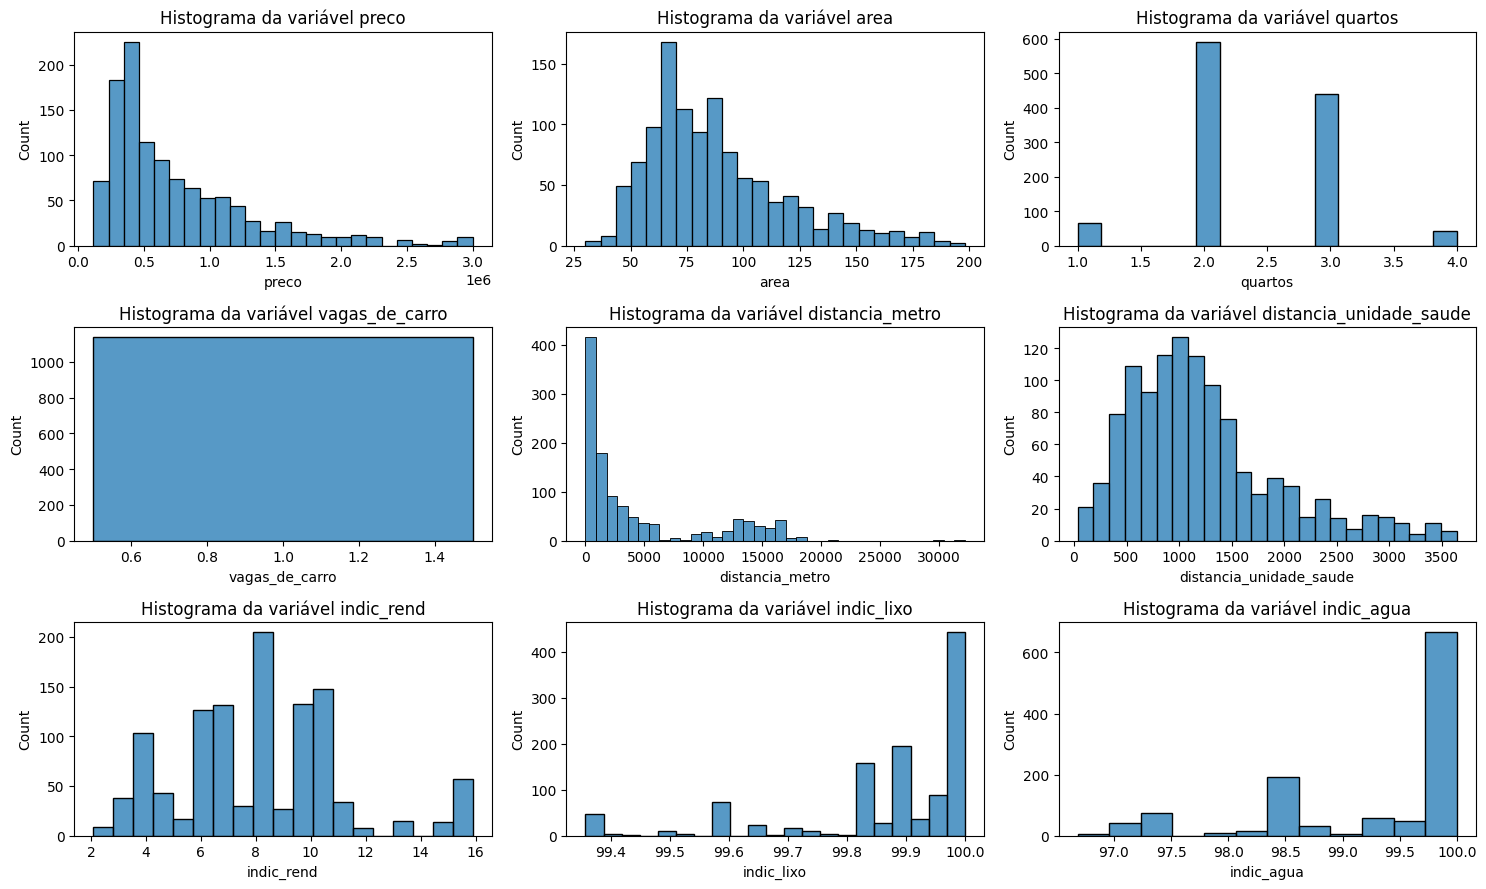

In [22]:
plotar_boxplot(dataframe_final, colunas_analise, tipo="histograma")

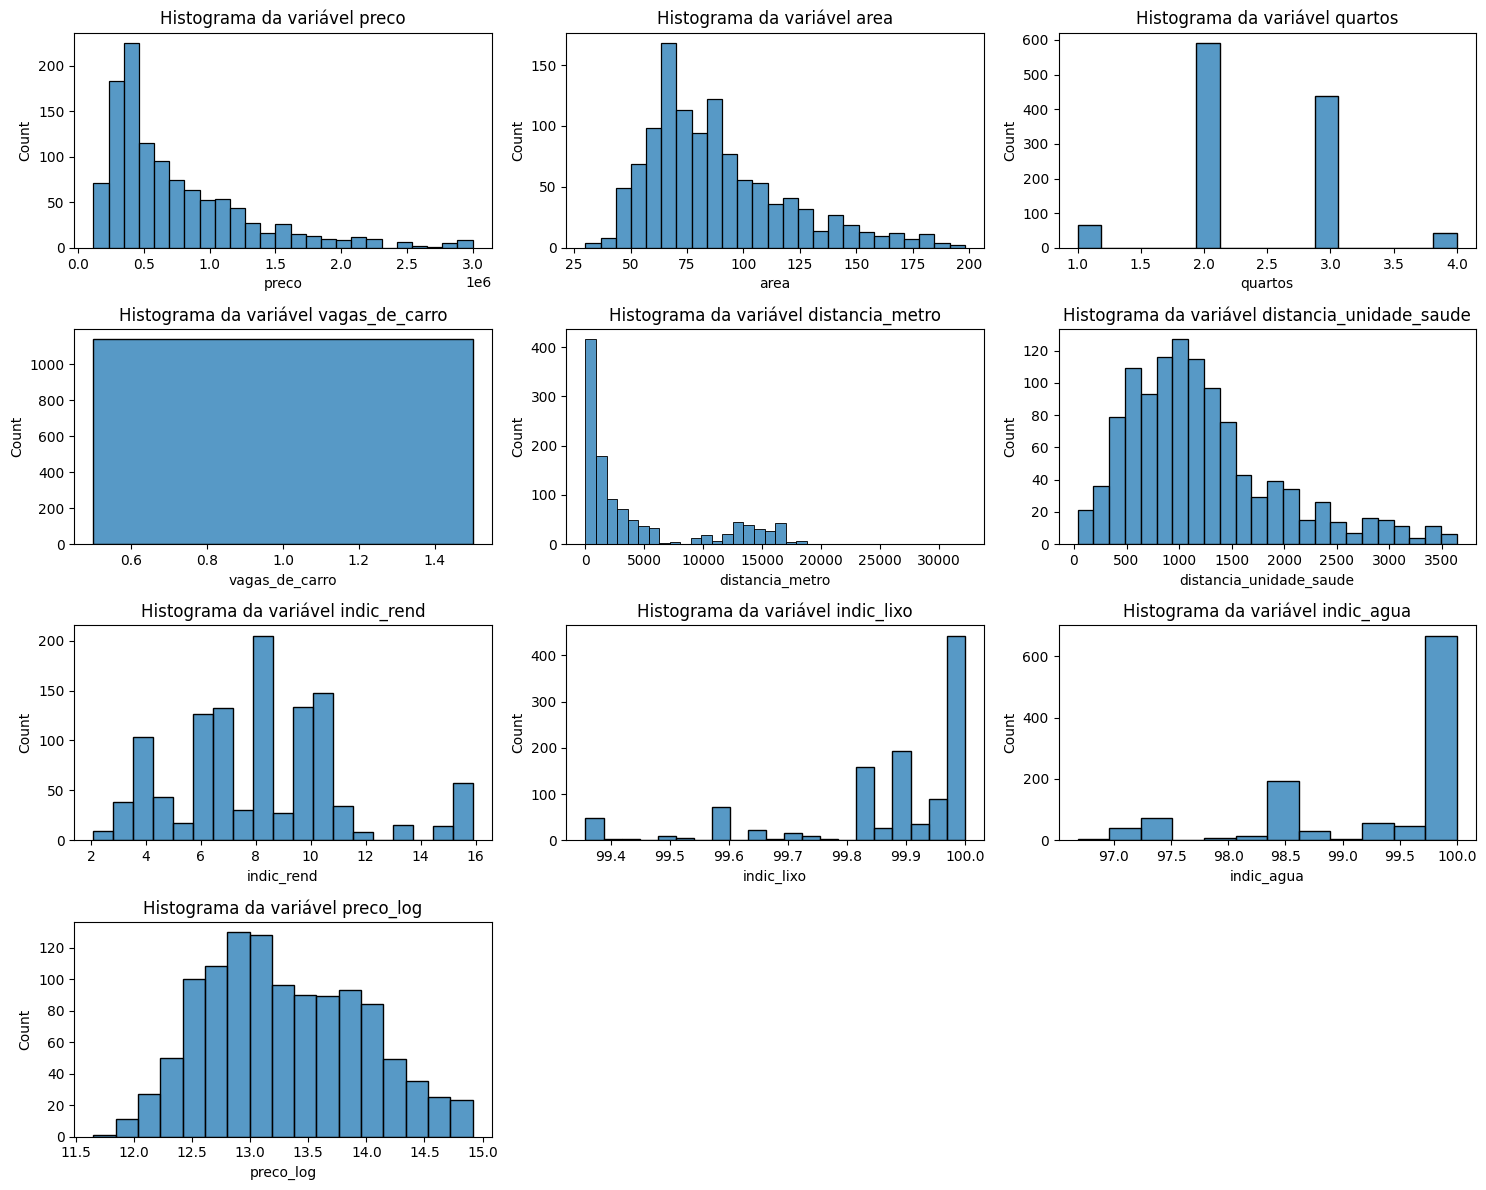

In [23]:
dataframe_final['preco_log'] = np.log(dataframe_final['preco'] + 1)

plotar_boxplot(dataframe_final, colunas_analise + ["preco_log"], tipo="histograma")

In [24]:
dataframe_final.to_parquet('dados_webscraping/dataframe_imoveis_venda_pronto_para_predicao_v2.parquet')